In [3]:
from __future__ import division
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from shapely.geometry import Point
from sklearn import neighbors

sns.set(style="white")
sns.set_context({"figure.figsize": (24, 10)})

pd.options.display.float_format = '{:.2f}'.format

abb_link = './tfg/dbases/development3.csv'
zc_link = './tfg/mapas/barrios_area.shp'

muestra = pd.read_csv(abb_link)
barrios = gpd.read_file(zc_link)

geometry = [Point(xy) for xy in zip(muestra['lon'], muestra['lat'])]
crs = {'init': 'epsg:4326'}
geo_df = GeoDataFrame(muestra, crs=crs, geometry=geometry)

db = gpd.sjoin(geo_df, barrios, how="inner", op='intersects')

metro = pd.read_csv('./tfg/dbases/distance_matrix_metro.csv')

db = db.join(metro.set_index('InputID'),
                            on='id', how='left')

db = db.rename(index=str, columns={"DESBDT": "subdistrict_f", "Distance": "metro_distance", "NUMPOINTS": "metro_number"})

db = pd.DataFrame(db)
db['floor']=db['floor'].replace(['Ground floor', 'Mezzanine', 'Semi-basement', 'Basement', 'ground', 'Floor -2', 'Floor -1'], 0,regex=True)
#db.replace(u'\xe', 'A')
db['floor'] = pd.to_numeric(db['floor'])

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pysal as ps
import geopandas as gpd
from sklearn import cluster
from sklearn.preprocessing import scale

Agregaci\'on de variables a nivel barrio

In [9]:
db.loc[:,varis].describe()

,pricems,rooms,floor,needs_renovating,garden,terrace,rooms,new_dev,garage
count,19177.00,19177.00,19177.00,19177.00,19177.00,19177.00,19177.00,19177.00,19177.00
mean,3288.34,3.01,3.02,0.18,0.27,0.42,3.01,0.03,0.34
std,1755.78,1.28,2.65,0.38,0.45,0.49,1.28,0.17,0.47
min,468.85,1.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00
25%,2000.00,2.00,1.00,0.00,0.00,0.00,2.00,0.00,0.00
50%,3000.00,3.00,2.00,0.00,0.00,0.00,3.00,0.00,0.00
75%,4109.59,4.00,4.00,0.00,1.00,1.00,4.00,0.00,1.00
max,23787.53,25.00,60.00,1.00,1.00,1.00,25.00,1.00,1.00


In [8]:
db['metro_number'].describe()

count   19177.00
mean        6.00
std         4.14
min         0.00
25%         3.00
50%         5.00
75%         9.00
max        16.00
Name: metro_number, dtype: float64

In [6]:
db.dtypes

Unnamed: 0            int64
id                  float64
price               float64
ms                    int64
rooms               float64
floor                 int64
lat                 float64
lon                 float64
air_conditioning      int64
wardrobes             int64
lift                  int64
exterior              int64
garden                int64
swimming_pool         int64
terrace               int64
storeroom             int64
garage                int64
district             object
subdistrict          object
share_loc             int64
needs_renovating      int64
good_condition        int64
new_dev               int64
pricems             float64
geometry             object
index_right           int64
CODBDT                int64
subdistrict_f        object
GEOCODIGO            object
metro_number          int64
area_n                int64
TargetID            float64
metro_distance      float64
dtype: object

In [50]:
varis = ['pricems', 'rooms', 'floor', 'needs_renovating', 'garden', 'terrace', 'new_dev', 'garage']

In [10]:
aves = db.groupby('GEOCODIGO')[varis].mean()
aves.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 079011 to 079215
Data columns (total 9 columns):
pricems             128 non-null float64
rooms               128 non-null float64
floor               128 non-null float64
needs_renovating    128 non-null float64
garden              128 non-null float64
terrace             128 non-null float64
rooms               128 non-null float64
new_dev             128 non-null float64
garage              128 non-null float64
dtypes: float64(9)
memory usage: 10.0+ KB


In [157]:
aves

,pricems,rooms,floor,needs_renovating,terrace,rooms,new_dev,garage
GEOCODIGO,,,,,,,,
079011,4303.37,2.61,2.48,0.19,0.16,2.61,0.00,0.08
079012,3573.84,2.39,2.28,0.18,0.17,2.39,0.00,0.05
079013,4479.07,3.44,2.37,0.30,0.14,3.44,0.05,0.14
079014,5280.17,3.07,2.62,0.20,0.21,3.07,0.03,0.18
079015,4402.41,2.61,2.94,0.18,0.22,2.61,0.03,0.08
079016,4489.82,3.36,3.11,0.21,0.19,3.36,0.00,0.02
079021,3189.81,2.77,2.96,0.19,0.42,2.77,0.00,0.16
079022,3365.35,2.56,2.95,0.17,0.33,2.56,0.00,0.14
079023,2942.19,2.86,2.88,0.30,0.35,2.86,0.00,0.07


In [12]:
types = pd.get_dummies(db['metro_number'])
prop_types = types.join(db['GEOCODIGO'])\
                    .groupby('GEOCODIGO')\
                    .sum()
prop_types_pct = (prop_types * 100).div(prop_types)
prop_types_pct.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 079011 to 079215
Data columns (total 17 columns):
0     19 non-null float64
1     8 non-null float64
2     15 non-null float64
3     15 non-null float64
4     18 non-null float64
5     10 non-null float64
6     7 non-null float64
7     10 non-null float64
8     8 non-null float64
9     1 non-null float64
10    4 non-null float64
11    4 non-null float64
12    4 non-null float64
13    2 non-null float64
14    1 non-null float64
15    1 non-null float64
16    1 non-null float64
dtypes: float64(17)
memory usage: 18.0+ KB


In [13]:
aves_props = aves.join(prop_types_pct)
#eliminar valores nulos
aves_props = aves_props.fillna(value=0)

In [14]:
db1 = pd.DataFrame(\
                 scale(aves_props), \
                 index=aves_props.index, \
                 columns=aves_props.columns)\
       #.rename(lambda x: str(int(x))              )


In [16]:
#zc = gpd.read_file(zc_link)
#zc.plot(color='green')
#sns.plt.show()

In [162]:
db1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 079011 to 079215
Data columns (total 25 columns):
pricems             128 non-null float64
rooms               128 non-null float64
floor               128 non-null float64
needs_renovating    128 non-null float64
terrace             128 non-null float64
rooms               128 non-null float64
new_dev             128 non-null float64
garage              128 non-null float64
0                   128 non-null float64
1                   128 non-null float64
2                   128 non-null float64
3                   128 non-null float64
4                   128 non-null float64
5                   128 non-null float64
6                   128 non-null float64
7                   128 non-null float64
8                   128 non-null float64
9                   128 non-null float64
10                  128 non-null float64
11                  128 non-null float64
12                  128 non-null float64
13                  128 non-nul

In [17]:
#zdb = db1.set_index('subdistrict_f').join(zc[['DESBDT', 'geometry']], on='DESBDT').dropna()

zdb = zc[['geometry', 'GEOCODIGO']].join(db1, on='GEOCODIGO')\
                                         .dropna()

In [164]:
zdb

,geometry,GEOCODIGO,pricems,rooms,floor,needs_renovating,terrace,rooms,new_dev,garage,...,7,8,9,10,11,12,13,14,15,16
0,POLYGON ((-3.709387921226222 40.42245753407111...,079011,1.06,-0.73,-0.61,0.30,-2.11,-0.73,-0.36,-1.15,...,-0.29,-0.26,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09
1,"POLYGON ((-3.702839417757738 40.4139218689474,...",079012,0.45,-1.17,-0.85,0.22,-2.08,-1.17,-0.32,-1.27,...,-0.29,-0.26,11.27,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09
2,POLYGON ((-3.696964466155972 40.41895010196534...,079013,1.20,1.02,-0.74,1.39,-2.33,1.02,0.27,-0.90,...,-0.29,3.87,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09
3,POLYGON ((-3.699419604899507 40.42842378657503...,079014,1.87,0.24,-0.43,0.43,-1.73,0.24,0.06,-0.72,...,-0.29,-0.26,-0.09,-0.18,-0.18,5.57,-0.13,-0.09,-0.09,-0.09
4,POLYGON ((-3.712238928618468 40.43022529948269...,079015,1.14,-0.72,-0.04,0.22,-1.62,-0.72,0.04,-1.13,...,-0.29,-0.26,-0.09,-0.18,-0.18,5.57,-0.13,-0.09,-0.09,-0.09
5,POLYGON ((-3.704164127607747 40.42018917644739...,079016,1.21,0.85,0.17,0.53,-1.88,0.85,-0.36,-1.37,...,-0.29,-0.26,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,11.27,-0.09
6,POLYGON ((-3.714653734661522 40.40017001671615...,079021,0.13,-0.39,-0.01,0.29,0.04,-0.39,-0.36,-0.77,...,-0.29,-0.26,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09
7,POLYGON ((-3.704378357831487 40.39534252885921...,079022,0.27,-0.83,-0.03,0.08,-0.71,-0.83,-0.36,-0.86,...,3.44,-0.26,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09
8,"POLYGON ((-3.69777391612309 40.38929634997568,...",079023,-0.08,-0.19,-0.11,1.48,-0.59,-0.19,-0.36,-1.18,...,-0.29,-0.26,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09
9,POLYGON ((-3.677683491441507 40.39329718871196...,079024,0.84,-1.04,1.60,-1.09,-1.07,-1.04,1.22,0.58,...,-0.29,-0.26,-0.09,-0.18,-0.18,-0.18,-0.13,-0.09,-0.09,-0.09


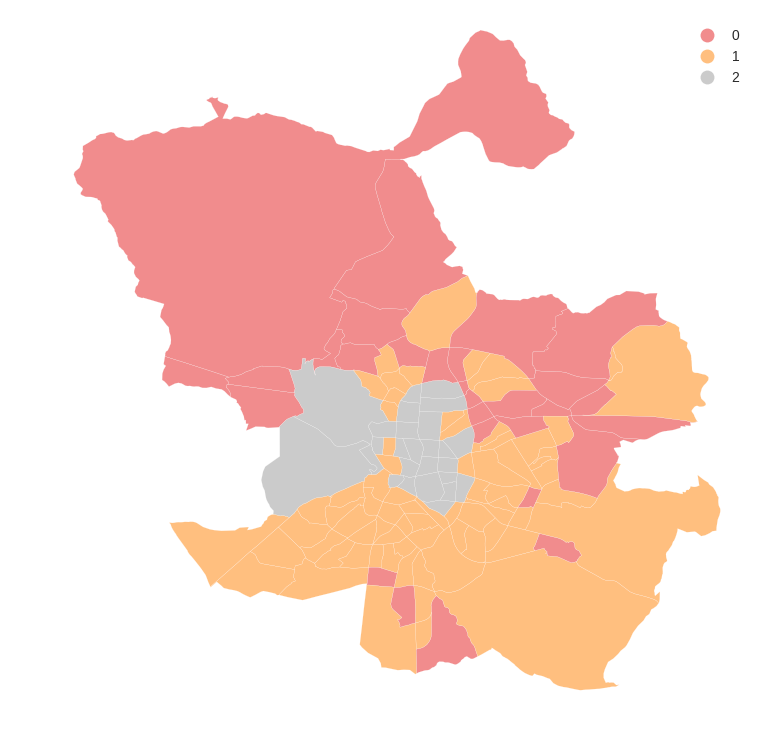

In [46]:
km5 = cluster.KMeans(n_clusters=3)
km5cls = km5.fit(zdb.drop(['geometry', 'GEOCODIGO'], axis=1).values)
f, ax = plt.subplots(1, figsize=(9, 9))

zdb.assign(cl=km5cls.labels_)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)
ax.set_axis_off()
plt.show()


In [47]:
km5cls.labels_

array([1, 1, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 2, 2, 1, 2,
       2, 2, 2, 1, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 2, 1, 2, 2, 2, 2, 0, 0, 0,
       1, 0, 1, 0, 0, 2, 2, 2, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0], dtype=int32)

In [48]:
cl_pcts = prop_types_pct.reindex(zdb['GEOCODIGO'])\
                          .assign(cl=km5cls.labels_)\
                          .groupby('cl')\
                          .count()

N\'umero de bocas de metro en los barrios que componen la zona

In [49]:
cl_pcts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
cl,,,,,,,,,,,,,,,,,
0,11,3,3,4,2,1,2,2,0,0,0,0,0,1,0,0,0
1,8,4,11,11,14,5,4,6,3,1,2,1,2,0,1,0,0
2,0,1,1,0,2,4,1,2,5,0,2,3,2,1,0,1,1


In [44]:
f, ax = plt.subplots(1, figsize=(18, 9))
cl_pcts.plot(kind='bar', stacked=False, ax=ax, \
             cmap='Set2', linewidth=2)
ax.legend(ncol=1, loc="right");

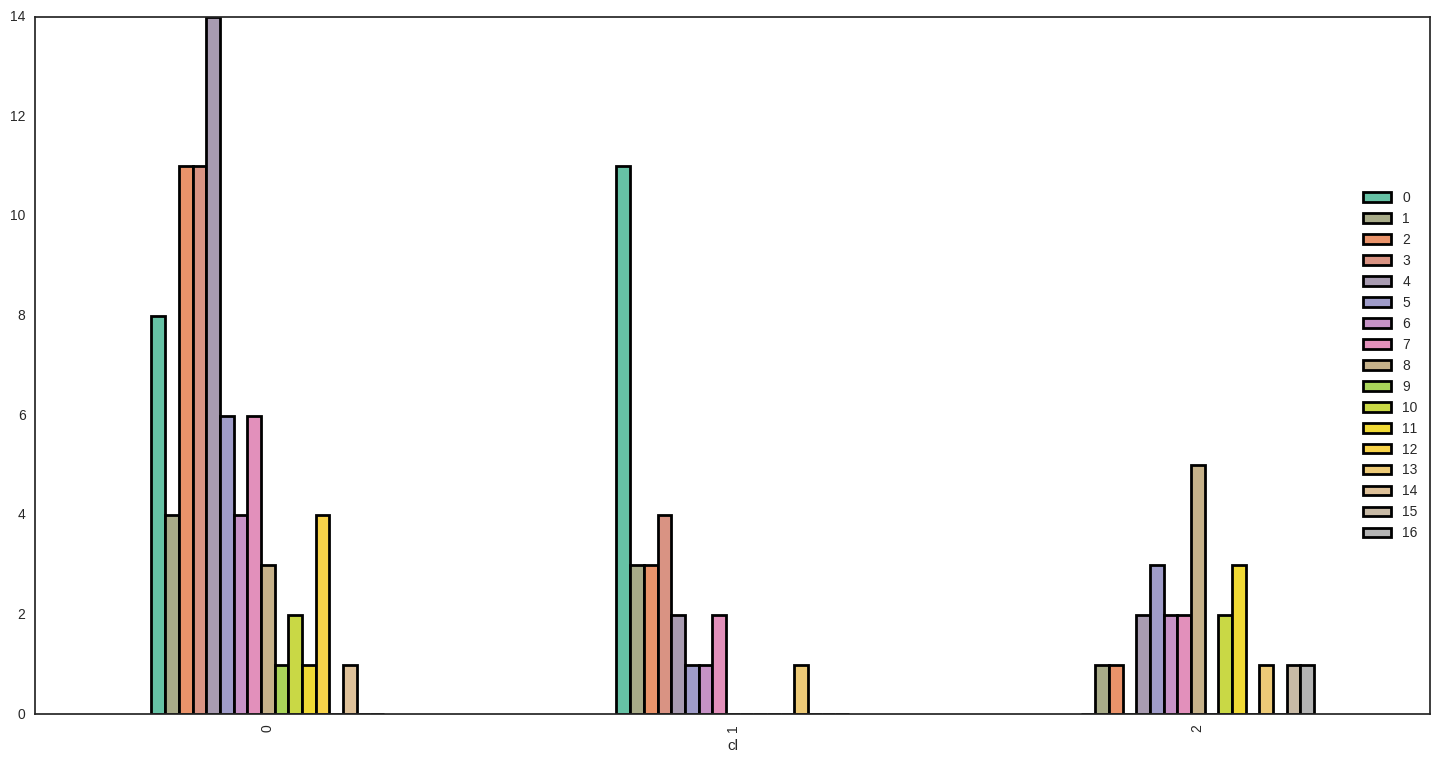

In [45]:
plt.show()

In [176]:
type(cl_pcts)

pandas.core.frame.DataFrame

In [226]:
zdb.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 128 entries, 0 to 127
Data columns (total 27 columns):
geometry            128 non-null object
GEOCODIGO           128 non-null object
pricems             128 non-null float64
rooms               128 non-null float64
floor               128 non-null float64
needs_renovating    128 non-null float64
terrace             128 non-null float64
rooms               128 non-null float64
new_dev             128 non-null float64
garage              128 non-null float64
0                   128 non-null float64
1                   128 non-null float64
2                   128 non-null float64
3                   128 non-null float64
4                   128 non-null float64
5                   128 non-null float64
6                   128 non-null float64
7                   128 non-null float64
8                   128 non-null float64
9                   128 non-null float64
10                  128 non-null float64
11                  128 non-

In [51]:
rt_av = db.groupby('GEOCODIGO')[varis]\
           .mean()\
           .rename(lambda x: str(int(x)))
           
#pasar a int para join
#rt_av.index = rt_av.index.astype(int)

In [52]:
rt_av.describe()

,pricems,rooms,floor,needs_renovating,garden,terrace,new_dev,garage
count,128.00,128.00,128.00,128.00,128.00,128.00,128.00,128.00
mean,3038.07,2.95,2.97,0.16,0.31,0.42,0.03,0.35
std,1200.85,0.48,0.82,0.10,0.26,0.12,0.08,0.24
min,1177.56,2.03,1.24,0.00,0.00,0.14,0.00,0.00
25%,2008.79,2.62,2.46,0.09,0.10,0.35,0.00,0.16
50%,2884.95,2.81,2.87,0.16,0.21,0.42,0.00,0.28
75%,3740.04,3.36,3.36,0.23,0.49,0.49,0.01,0.47
max,7070.90,4.11,5.69,0.40,0.93,0.88,0.57,0.92


In [53]:
zc['GEOCODIGO'] = pd.to_numeric(zc['GEOCODIGO'])

In [54]:
#pasar a int para join
rt_av.index = rt_av.index.astype(int)


zrt = zc[['geometry', 'GEOCODIGO']].join(rt_av, on='GEOCODIGO')\
                                         .dropna()
zrt.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 128 entries, 0 to 127
Data columns (total 10 columns):
geometry            128 non-null object
GEOCODIGO           128 non-null int64
pricems             128 non-null float64
rooms               128 non-null float64
floor               128 non-null float64
needs_renovating    128 non-null float64
garden              128 non-null float64
terrace             128 non-null float64
new_dev             128 non-null float64
garage              128 non-null float64
dtypes: float64(8), int64(1), object(1)
memory usage: 11.0+ KB


In [230]:
zrt

,geometry,GEOCODIGO,pricems,rooms,floor,needs_renovating,garden,terrace,rooms,new_dev,garage
0,POLYGON ((-3.709387921226222 40.42245753407111...,79011,4303.37,2.61,2.48,0.19,0.04,0.16,2.61,0.00,0.08
1,"POLYGON ((-3.702839417757738 40.4139218689474,...",79012,3573.84,2.39,2.28,0.18,0.02,0.17,2.39,0.00,0.05
2,POLYGON ((-3.696964466155972 40.41895010196534...,79013,4479.07,3.44,2.37,0.30,0.01,0.14,3.44,0.05,0.14
3,POLYGON ((-3.699419604899507 40.42842378657503...,79014,5280.17,3.07,2.62,0.20,0.01,0.21,3.07,0.03,0.18
4,POLYGON ((-3.712238928618468 40.43022529948269...,79015,4402.41,2.61,2.94,0.18,0.02,0.22,2.61,0.03,0.08
5,POLYGON ((-3.704164127607747 40.42018917644739...,79016,4489.82,3.36,3.11,0.21,0.00,0.19,3.36,0.00,0.02
6,POLYGON ((-3.714653734661522 40.40017001671615...,79021,3189.81,2.77,2.96,0.19,0.21,0.42,2.77,0.00,0.16
7,POLYGON ((-3.704378357831487 40.39534252885921...,79022,3365.35,2.56,2.95,0.17,0.11,0.33,2.56,0.00,0.14
8,"POLYGON ((-3.69777391612309 40.38929634997568,...",79023,2942.19,2.86,2.88,0.30,0.10,0.35,2.86,0.00,0.07
9,POLYGON ((-3.677683491441507 40.39329718871196...,79024,4042.00,2.46,4.28,0.06,0.58,0.29,2.46,0.12,0.48


In [55]:

zrt.to_file('tmp')
#matriz de pesos espaciales
w = ps.queen_from_shapefile('tmp/tmp.shp', idVariable='GEOCODIGO')

#rm -r tmp
w

Establecer minimo de viviendas para region

In [56]:
n_rev = db.groupby('GEOCODIGO')\
           .count()\
           ['price']\
           
thr = np.round(0.1 * n_rev.sum())
thr

1918.0

In [57]:
np.random.seed(1234)
z = zrt.drop(['geometry', 'GEOCODIGO'], axis=1).values
maxp = ps.region.Maxp(w, z, thr, n_rev, initial=1000)


Inferencia para comprobar que los resultados son mejores que definiendo zonas al azar

In [220]:

np.random.seed(1234)
maxp.cinference(nperm=20)


maxp.cpvalue


0.047619047619047616

In [58]:
lbls = pd.Series(maxp.area2region).reindex(zrt['GEOCODIGO'])


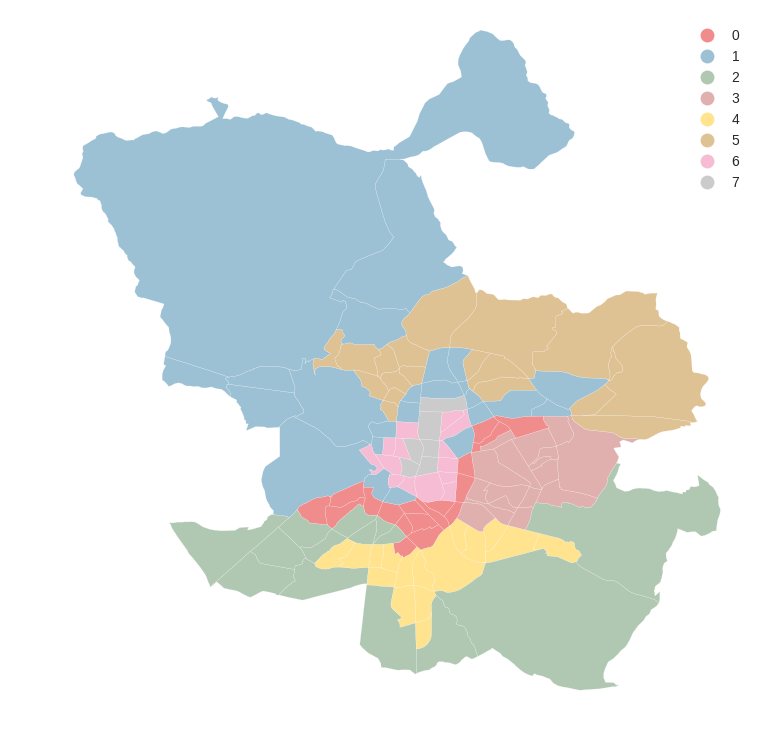

In [59]:

f, ax = plt.subplots(1, figsize=(9, 9))

zrt.assign(cl=lbls.values)\
   .plot(column='cl', categorical=True, legend=True, \
         linewidth=0.1, edgecolor='white', ax=ax)

ax.set_axis_off()

plt.show()


In [217]:
lbls

GEOCODIGO
79011    1
79012    1
79013    6
79014    7
79015    6
79016    6
79021    0
79022    0
79023    0
79024    0
79025    0
79026    0
79027    0
79031    0
79032    0
79033    0
79034    6
79035    6
79036    6
79041    7
79042    6
79043    0
79044    1
79045    6
79046    7
79051    7
79052    6
79053    6
79054    7
79055    1
        ..
79158    1
79159    1
79161    1
79162    1
79163    5
79164    5
79165    5
79166    5
79171    2
79172    4
79173    2
79174    4
79175    4
79181    2
79182    4
79191    2
79192    3
79201    3
79202    3
79203    3
79204    3
79205    3
79206    5
79207    3
79208    0
79211    5
79212    5
79213    5
79214    5
79215    1
dtype: int64

In [60]:

#ver stats
zrt[varis].groupby(lbls.values).mean().T

,0,1,2,3,4,5,6,7
pricems,3066.53,3856.76,1979.78,2120.01,1587.31,2805.10,4557.58,5809.32
rooms,2.76,3.34,2.56,2.75,2.74,2.80,3.28,3.76
floor,2.85,2.97,2.71,3.00,3.02,2.93,3.23,3.28
needs_renovating,0.16,0.17,0.12,0.15,0.10,0.14,0.27,0.29
garden,0.28,0.48,0.32,0.26,0.23,0.43,0.08,0.11
terrace,0.40,0.48,0.41,0.37,0.46,0.45,0.33,0.42
new_dev,0.02,0.02,0.06,0.00,0.04,0.05,0.01,0.01
garage,0.26,0.55,0.34,0.26,0.27,0.42,0.19,0.39


In [1]:

#ver stats
zrt[varis].groupby(lbls.values).mean().T

NameError: name 'zrt' is not defined